In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [2]:
import numpy as np
import scipy.sparse as sp
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from keras import initializers
from keras.models import Sequential, Model, load_model, save_model
from keras.layers.core import Dense, Lambda, Activation
from keras.layers import Embedding, Input, Dense, Multiply, Reshape, Flatten, Concatenate
from keras.optimizers import Adam
from keras.regularizers import l2
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import json, sys, random, os, datetime, math
print(tf.__version__)
print(keras.__version__)



2.3.0
2.4.0


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#Data Pre-processing


In [3]:
from_json_df = pd.read_json('/content/gdrive/My Drive/cmpe256-homework2/video_bundle_data2.json')

In [4]:
from_json_df.head(5)

,bundle_final_price,bundle_url,bundle_price,bundle_name,bundle_id,items,bundle_discount
0,$66.46,http://store.steampowered.com/bundle/450/?utm_...,$73.86,Dharker Studio 2015 Complete,450,"[{'genre': 'Adventure, Indie, RPG', 'item_id':...",10%
1,$20.15,http://store.steampowered.com/bundle/1473/?utm...,$25.87,"Naruto Shippuden Uncut Season 4, Vol. 3",1473,"[{'genre': '', 'item_id': '528360', 'discounte...",22%
2,$20.15,http://store.steampowered.com/bundle/1474/?utm...,$25.87,"Naruto Shippuden Uncut Season 4, Vol. 4",1474,"[{'genre': '', 'item_id': '528380', 'discounte...",22%
3,$15.17,http://store.steampowered.com/bundle/1437/?utm...,$25.35,Pixel Puzzles Ultimate: Starter Kit,1437,"[{'genre': 'Casual, Free to Play, Indie, Simul...",40%
4,$20.15,http://store.steampowered.com/bundle/1466/?utm...,$25.87,"Naruto Shippuden Uncut Season 4, Vol. 1",1466,"[{'genre': '', 'item_id': '527830', 'discounte...",22%


In [5]:
data = from_json_df[['bundle_name','bundle_id','items']]

In [6]:
data.head()

,bundle_name,bundle_id,items
0,Dharker Studio 2015 Complete,450,"[{'genre': 'Adventure, Indie, RPG', 'item_id':..."
1,"Naruto Shippuden Uncut Season 4, Vol. 3",1473,"[{'genre': '', 'item_id': '528360', 'discounte..."
2,"Naruto Shippuden Uncut Season 4, Vol. 4",1474,"[{'genre': '', 'item_id': '528380', 'discounte..."
3,Pixel Puzzles Ultimate: Starter Kit,1437,"[{'genre': 'Casual, Free to Play, Indie, Simul..."
4,"Naruto Shippuden Uncut Season 4, Vol. 1",1466,"[{'genre': '', 'item_id': '527830', 'discounte..."


In [7]:
items_split_array = []
for index, row in data.iterrows():
  for item in row['items']:
    items_split_array.append([item['item_id'], item['item_name'], item['genre'], row['bundle_id']])
df = pd.DataFrame(items_split_array, columns=['item_id', 'item_name', 'genre', 'bundle_id'])
print(df.shape)
df.head()

(3525, 4)


,item_id,item_name,genre,bundle_id
0,326950,Sword of Asumi,"Adventure, Indie, RPG",450
1,331490,Sword of Asumi - Soundtrack,"Adventure, Indie, RPG",450
2,331491,Sword of Asumi - Graphic Novel,"Adventure, Indie, RPG",450
3,331492,Sword of Asumi - Character Creator,"Adventure, Indie, RPG",450
4,348540,Divine Slice of Life,"Adventure, Casual, Indie",450


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3525 entries, 0 to 3524
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   item_id    3525 non-null   object
 1   item_name  3525 non-null   object
 2   genre      3525 non-null   object
 3   bundle_id  3525 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 110.3+ KB


In [9]:
df.describe()

,bundle_id
count,3525.000000
mean,715.415603
std,396.726058
min,15.000000
25%,362.000000
50%,634.000000
75%,1028.000000
max,1482.000000


In [10]:
df[df.genre == ''].shape[0]

345

In [11]:
df['genre'].isin(['Action']).sum(axis=0)

261

In [12]:
df.genre.value_counts()

                                                                          345
Action                                                                    261
Action, Adventure                                                         192
Action, Indie                                                             134
Strategy                                                                  121
                                                                         ... 
Strategy, Indie, Action                                                     1
Action, Adventure, Casual, Indie, Massively Multiplayer, RPG, Strategy      1
Adventure, Casual, Indie, RPG, Simulation, Strategy                         1
Action, Casual, Indie, Sports                                               1
Action, Indie, Massively Multiplayer, Early Access                          1
Name: genre, Length: 197, dtype: int64

In [13]:
df['genre'].nunique()

197

In [14]:
genres_list = df['genre'].tolist()

In [15]:
genre_set=set()
for item in genres_list:
  genres = (item.split(','))
  for i in genres:
    genre_set.add(i)
genre_set

{'',
 ' Action',
 ' Adventure',
 ' Casual',
 ' Design & Illustration',
 ' Early Access',
 ' Education',
 ' Free to Play',
 ' Indie',
 ' Massively Multiplayer',
 ' Photo Editing',
 ' RPG',
 ' Racing',
 ' Simulation',
 ' Software Training',
 ' Sports',
 ' Strategy',
 ' Utilities',
 ' Video Production',
 ' Web Publishing',
 'Action',
 'Adventure',
 'Animation & Modeling',
 'Audio Production',
 'Casual',
 'Design & Illustration',
 'Education',
 'Free to Play',
 'Indie',
 'Massively Multiplayer',
 'RPG',
 'Racing',
 'Simulation',
 'Software Training',
 'Sports',
 'Strategy',
 'Utilities',
 'Web Publishing'}

In [16]:
len(genre_set)

38

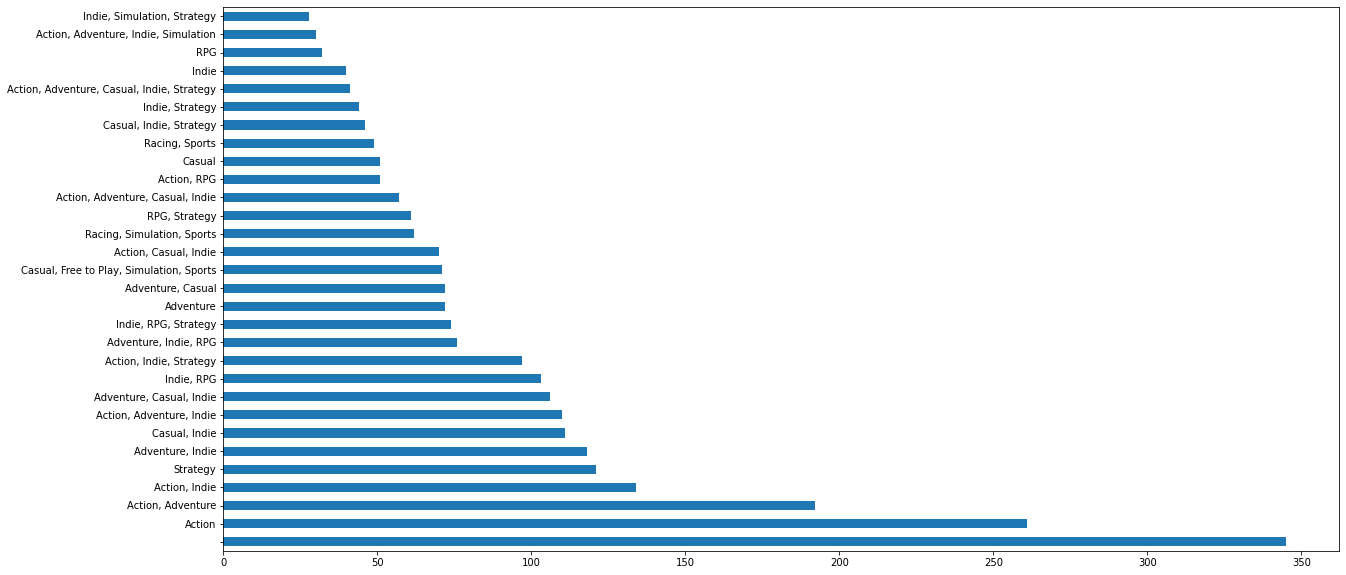

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
df['genre'].value_counts().head(30).plot(kind='barh', figsize=(20,10))

In [18]:
df["genre"].replace([""], "Others", inplace=True)

In [19]:
df.genre.value_counts()

Others                                                                    345
Action                                                                    261
Action, Adventure                                                         192
Action, Indie                                                             134
Strategy                                                                  121
                                                                         ... 
Action, Adventure, Casual, Indie, Massively Multiplayer, RPG, Strategy      1
Strategy, Indie, Action                                                     1
Action, Indie, Massively Multiplayer, Early Access                          1
Massively Multiplayer, Strategy                                             1
Adventure, Casual, Indie, Simulation, Strategy                              1
Name: genre, Length: 197, dtype: int64

In [20]:
plt.figure

<function matplotlib.pyplot.figure>

In [21]:
item_ids = df["item_id"].unique().tolist()
len(item_ids)
item2item_encoded = {x: i for i, x in enumerate(item_ids)}
item_encoded2item = {i: x for i, x in enumerate(item_ids)}
df['itemId'] = df["item_id"].map(item2item_encoded)

df.head()

,item_id,item_name,genre,bundle_id,itemId
0,326950,Sword of Asumi,"Adventure, Indie, RPG",450,0
1,331490,Sword of Asumi - Soundtrack,"Adventure, Indie, RPG",450,1
2,331491,Sword of Asumi - Graphic Novel,"Adventure, Indie, RPG",450,2
3,331492,Sword of Asumi - Character Creator,"Adventure, Indie, RPG",450,3
4,348540,Divine Slice of Life,"Adventure, Casual, Indie",450,4


In [22]:
bundle_ids = df["bundle_id"].unique().tolist()
bundle2bundle_encoded = {x: i for i, x in enumerate(bundle_ids)}
bundle_encoded2bundle = {i: x for i, x in enumerate(bundle_ids)}
df["bundleId"] = df["bundle_id"].map(bundle2bundle_encoded)
df.head()

,item_id,item_name,genre,bundle_id,itemId,bundleId
0,326950,Sword of Asumi,"Adventure, Indie, RPG",450,0,0
1,331490,Sword of Asumi - Soundtrack,"Adventure, Indie, RPG",450,1,0
2,331491,Sword of Asumi - Graphic Novel,"Adventure, Indie, RPG",450,2,0
3,331492,Sword of Asumi - Character Creator,"Adventure, Indie, RPG",450,3,0
4,348540,Divine Slice of Life,"Adventure, Casual, Indie",450,4,0


In [23]:
df.bundleId.min()

0

In [24]:
df.bundleId.max()

614

In [25]:
# split training and validation data
split = np.random.rand(len(df)) < 0.8
train = df[split]
validate = df[~split]
train.head()

,item_id,item_name,genre,bundle_id,itemId,bundleId
1,331490,Sword of Asumi - Soundtrack,"Adventure, Indie, RPG",450,1,0
2,331491,Sword of Asumi - Graphic Novel,"Adventure, Indie, RPG",450,2,0
4,348540,Divine Slice of Life,"Adventure, Casual, Indie",450,4,0
6,390470,Divine Slice of Life - Soundtrack,"Adventure, Casual, Indie",450,6,0
8,398100,Highschool Romance,"Casual, Indie",450,8,0


In [26]:
validate.head()

,item_id,item_name,genre,bundle_id,itemId,bundleId
0,326950,Sword of Asumi,"Adventure, Indie, RPG",450,0,0
3,331492,Sword of Asumi - Character Creator,"Adventure, Indie, RPG",450,3,0
5,352010,Beach Bounce,"Adventure, Casual, Indie",450,5,0
7,394050,Beach Bounce - Soundtrack,"Adventure, Casual, Indie",450,7,0
9,408770,Highschool Possession,"Adventure, Indie",450,9,0


In [27]:
#creating dot matrix which is a sparse matrix which specifies if a bundle has an item
# if a BundleId i has item j, mat[i,j]=1
mat = sp.dok_matrix((train.shape[0], len(df['itemId'].unique())), dtype=np.float32)
for bundle_id, item_id in zip(train['bundleId'], train['itemId']):
    mat[bundle_id, item_id] = 1.0

# Defining Model 


In [28]:
def get_NCF_model(num_bunldes, num_items, latent_dim=8, dense_layers=[64, 32, 16, 8],
              reg_layers=[0, 0, 0, 0], reg_mf=0):

    # input layer
    input_bundle = Input(shape=(1,), dtype='int32', name='bundle_input')
    input_item = Input(shape=(1,), dtype='int32', name='item_input')

    print(reg_mf)
    
    # embedding layer
    mf_bundle_embedding = Embedding(input_dim=num_bundles, output_dim=latent_dim,
                        name='mf_bundle_embedding',
                        embeddings_initializer='RandomNormal',
                        embeddings_regularizer=l2(reg_mf), input_length=1)
    mf_item_embedding = Embedding(input_dim=num_items, output_dim=latent_dim,
                        name='mf_item_embedding',
                        embeddings_initializer='RandomNormal',
                        embeddings_regularizer=l2(reg_mf), input_length=1)
    mlp_bundle_embedding = Embedding(input_dim=num_bundles, output_dim=int(dense_layers[0]/2),
                         name='mlp_bundle_embedding',
                         embeddings_initializer='RandomNormal',
                         embeddings_regularizer=l2(reg_layers[0]), 
                         input_length=1)
    mlp_item_embedding = Embedding(input_dim=num_items, output_dim=int(dense_layers[0]/2),
                         name='mlp_item_embedding',
                         embeddings_initializer='RandomNormal',
                         embeddings_regularizer=l2(reg_layers[0]), 
                         input_length=1)

    # MF latent vector
    mf_bundle_latent = Flatten()(mf_bundle_embedding(input_bundle))
    mf_item_latent = Flatten()(mf_item_embedding(input_item))
    mf_cat_latent = Multiply()([mf_bundle_latent, mf_item_latent])

    # MLP latent vector
    mlp_bundle_latent = Flatten()(mlp_bundle_embedding(input_bundle))
    mlp_item_latent = Flatten()(mlp_item_embedding(input_item))
    mlp_cat_latent = Concatenate()([mlp_bundle_latent, mlp_item_latent])
    
    mlp_vector = mlp_cat_latent
    
    # build dense layer for model
    for i in range(1,len(dense_layers)):
        layer = Dense(dense_layers[i],
                      activity_regularizer=l2(reg_layers[i]),
                      activation='relu',
                      name='layer%d' % i)
        mlp_vector = layer(mlp_vector)

    predict_layer = Concatenate()([mf_cat_latent, mlp_vector])
    result = Dense(1, activation='sigmoid', 
                   kernel_initializer='lecun_uniform',name='result')

    model = Model(inputs=[input_bundle,input_item], outputs=result(predict_layer))

    return model

# get the training samples
def get_train_samples(train_mat, num_negatives):
    bundle_input, item_input, labels = [], [], []
    num_bundle, num_item = train_mat.shape
    for (u, i) in train_mat.keys():
        bundle_input.append(u)
        item_input.append(i)
        labels.append(1)
        # negative instances
        for t in range(num_negatives):
            j = np.random.randint(num_item)
            while (u, j) in train_mat.keys():
                j = np.random.randint(num_item)
            bundle_input.append(u)
            item_input.append(j)
            labels.append(0)
    return bundle_input, item_input, labels

# hyperparameters

verbose = 1
epochs = 15   
batch_size = 256
latent_dim = 8
dense_layers = [64, 32, 16, 8]
reg_layers = [0, 0, 0, 0]
reg_mf = [0]
num_negatives = 4
learning_rate = 0.001
learner = 'adam'
dataset = 'steam_video'

# loading data
train_mat = mat
    
num_bundles, num_items = train_mat.shape
print('Done loading data!')

Done loading data!


In [29]:
model = get_NCF_model(num_bundles, num_items, latent_dim, dense_layers, reg_layers)
model.compile(optimizer=Adam(lr=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
print(model.summary())
    


0
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
bundle_input (InputLayer)       [(None, 1)]          0                                            
__________________________________________________________________________________________________
item_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
mlp_bundle_embedding (Embedding (None, 1, 32)        90880       bundle_input[0][0]               
__________________________________________________________________________________________________
mlp_item_embedding (Embedding)  (None, 1, 32)        89536       item_input[0][0]                 
_____________________________________________________________________________________

#Training

In [30]:

bundle_input, item_input, labels = get_train_samples(train_mat, num_negatives)

# training
hist = model.fit([np.array(bundle_input), np.array(item_input)], np.array(labels), 
                 batch_size=batch_size, epochs=epochs, verbose=verbose, shuffle=True)

Epoch 1/15


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


56/56 [==============================] - 0s 4ms/step - loss: 0.6861 - accuracy: 0.7174
Epoch 2/15
56/56 [==============================] - 0s 4ms/step - loss: 0.6693 - accuracy: 0.8000
Epoch 3/15
56/56 [==============================] - 0s 4ms/step - loss: 0.6544 - accuracy: 0.8000
Epoch 4/15
56/56 [==============================] - 0s 4ms/step - loss: 0.6401 - accuracy: 0.8000
Epoch 5/15
56/56 [==============================] - 0s 4ms/step - loss: 0.6260 - accuracy: 0.8000
Epoch 6/15
56/56 [==============================] - 0s 4ms/step - loss: 0.6113 - accuracy: 0.8000
Epoch 7/15
56/56 [==============================] - 0s 4ms/step - loss: 0.5951 - accuracy: 0.8000
Epoch 8/15
56/56 [==============================] - 0s 4ms/step - loss: 0.5766 - accuracy: 0.8000
Epoch 9/15
56/56 [==============================] - 0s 4ms/step - loss: 0.5550 - accuracy: 0.8007
Epoch 10/15
56/56 [==============================] - 0s 4ms/step - loss: 0.5291 - accuracy: 0.8078
Epoch 11/15
56/56 [===========

In [31]:
model_file = '%s_NCF_%d_%s.h5' % (dataset, latent_dim, str(dense_layers))
model.save(model_file, overwrite=True)

#Evaluation


In [88]:
from keras.models import load_model
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans

# this is a sample bundleid to predict
desired_bundle_id = 568
model_path = 'steam_video_NCF_8_[64, 32, 16, 8].h5'
print('using model: %s' % model_path)
model = load_model(model_path)
print('Loaded model!')

mlp_bundle_embedding_weights = (next(iter(filter(lambda x: x.name == 'mlp_bundle_embedding', model.layers))).get_weights())

# get the latent embedding for your desired bundle
bundle_latent_matrix = mlp_bundle_embedding_weights[0]
one_bundle_vector = bundle_latent_matrix[desired_bundle_id,:]
one_bundle_vector = np.reshape(one_bundle_vector, (1,32))

print('\nPerforming kmeans to find the nearest bundles...')
# get 50 similar bundles
kmeans = MiniBatchKMeans(n_clusters=50, random_state=0, verbose=1).fit(bundle_latent_matrix)
desired_bundle_label = kmeans.predict(one_bundle_vector)
bundle_label = kmeans.labels_
neighbors = []
for bundle_id, bundle_label in enumerate(bundle_label):
    if bundle_label == desired_bundle_label:
        neighbors.append(bundle_id)
print('Found {0} neighbor bundles/games.'.format(len(neighbors))) 

using model: steam_video_NCF_8_[64, 32, 16, 8].h5
Loaded model!

Performing kmeans to find the nearest bundles...
Init 1/3 with method: k-means++
Inertia for init 1/3: 20.312521
Init 2/3 with method: k-means++
Inertia for init 2/3: 20.073416
Init 3/3 with method: k-means++
Inertia for init 3/3: 20.587894
Minibatch iteration 1/2900: mean batch inertia: 0.085470, ewa inertia: 0.085470 
Minibatch iteration 2/2900: mean batch inertia: 0.082207, ewa inertia: 0.085240 
Minibatch iteration 3/2900: mean batch inertia: 0.080680, ewa inertia: 0.084919 
Minibatch iteration 4/2900: mean batch inertia: 0.081418, ewa inertia: 0.084673 
Minibatch iteration 5/2900: mean batch inertia: 0.080506, ewa inertia: 0.084379 
Minibatch iteration 6/2900: mean batch inertia: 0.079951, ewa inertia: 0.084068 
Minibatch iteration 7/2900: mean batch inertia: 0.083143, ewa inertia: 0.084003 
Minibatch iteration 8/2900: mean batch inertia: 0.077871, ewa inertia: 0.083571 
Minibatch iteration 9/2900: mean batch inertia

In [89]:
# get the games in similar bundles' items
games = []
for bundle_id in neighbors:
    games += list(df[df['bundleId'] == int(bundle_id)]['itemId'])
print('Found {0} neighbor items from these games.'.format(len(games))) 

games_arr = np.full(len(games), desired_bundle_id, dtype='int32')
bundles = np.array(games, dtype='int32')

print('\nRanking most likely games using the NeuMF model...')
# and predict games for bundle
results = model.predict([games_arr,bundles],batch_size=100, verbose=0) 
results = results.tolist()
print('Ranked the games!')

Found 55 neighbor items from these games.

Ranking most likely games using the NeuMF model...
Ranked the games!


In [90]:
results_df = pd.DataFrame(np.nan, index=range(len(results)), columns=['probability','item_name', 'genre'])
print(results_df.shape)

# loop through and get the probability (of being in the bundle according to my model), the game, and the genre  
for i, prob in enumerate(results):
    # print('i: {0} prob: {1}'.format(i,prob))
    results_df.loc[i] = [prob[0], df[df['itemId'] == i].iloc[0]['item_name'], df[df['itemId'] == i].iloc[0]['genre']]
results_df = results_df.sort_values(by=['probability'], ascending=False)

results_df.head(3)

(55, 3)


,probability,item_name,genre
35,0.572029,Naruto Shippuden Uncut: The Burden,Others
40,0.567164,Pixel Puzzles Ultimate - Puzzle Pack: Dinosaurs,"Casual, Free to Play, Indie, Simulation, Sport..."
38,0.525115,Naruto Shippuden Uncut: Infiltrator,Others


In [91]:
df[df['bundleId'] == 568].head(5)

,item_id,item_name,genre,bundle_id,itemId,bundleId
3295,317480,SpeedRunners - Youtuber Pack 1,"Action, Casual, Indie, Racing, Sports",435,2626,568
3296,317490,SpeedRunners - Youtuber Pack 2,"Action, Casual, Indie, Racing, Sports",435,2627,568
3297,207140,SpeedRunners,"Action, Casual, Indie, Racing, Sports",435,1511,568


In [36]:
#save df to json for inference
df.to_json(r'/content/origin_steam_video_df.json')

In [37]:
load_df = pd.read_json('/content/origin_steam_video_df.json')
load_df.head()

,item_id,item_name,genre,bundle_id,itemId,bundleId
0,326950,Sword of Asumi,"Adventure, Indie, RPG",450,0,0
1,331490,Sword of Asumi - Soundtrack,"Adventure, Indie, RPG",450,1,0
2,331491,Sword of Asumi - Graphic Novel,"Adventure, Indie, RPG",450,2,0
3,331492,Sword of Asumi - Character Creator,"Adventure, Indie, RPG",450,3,0
4,348540,Divine Slice of Life,"Adventure, Casual, Indie",450,4,0


In [38]:
from google.colab import files
files.download('/content/steam_video_NCF_8_[64, 32, 16, 8].h5') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [39]:
files.download('/content/origin_steam_video_df.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>